# Orthogonal quantile regression: A synthetic example

In this tutorial we will create synthetic p-dimensional heteroscedastic data, and compare the vanilla QR, and the proposed orthogonal quantile regression (OQR) alternative.



## Prediction intervals

Suppose we are given $ n $ training samples $ \{(X_i, Y_i)\}_{i=1}^n$ and we would like to predict the unknown value of $Y_{n+1}$ at a test point $X_{n+1}$. We assume that all the samples $ \{(X_i,Y_i)\}_{i=1}^{n+1} $ are drawn exchangeably$-$for instance, they may be drawn i.i.d.$-$from an arbitrary joint distribution $P_{XY}$ over the feature vectors $ X\in \mathbb{R}^p $ and response variables $ Y\in \mathbb{R} $. We aim to construct a marginal distribution-free prediction interval $C(X_{n+1}) \subseteq \mathbb{R}$ that is likely to contain the unknown response $Y_{n+1} $. That is, given a desired miscoverage rate $ \alpha $, we ask that
$$ \mathbb{P}\{Y_{n+1} \in C(X_{n+1})\} \geq 1-\alpha $$
for any joint distribution $ P_{XY} $ and any sample size $n$. The probability in this statement is marginal, being taken over all the samples $ \{(X_i, Y_i)\}_{i=1}^{n+1} $.


We start by defining the desired miscoverage rate (10% in our case), and the quantiles we are going to estimate for constructing a prediction interval.

In [1]:
# desired miscoverage error
alpha = 0.1
# low and high target quantiles
quantiles = [0.05, 0.95]

## Plotting helper functions

In [2]:
from scipy.stats import norm
import matplotlib.pyplot as plt
def conditional_quatile(x, quantile_level):
    sample_group = int(x[0])
    beta = betas[sample_group, :]
    c = (0.03*betas[0, :]@x).item()
    sigma = np.sqrt(c**2 + (sample_group*minority_lambda)**2)
    quantile_level = norm.ppf(quantile_level, loc=0, scale=sigma)
    return quantile_level

def plot_func(x, y, y_upper=None, y_lower=None, model_name=None, ax=None):
    x = np.array(x)
    y = np.array(y)
    if ax is None:
        figure = plt.figure()
        ax = figure.add_subplot(projection='3d')
        figure.set_figheight(10)
        figure.set_figwidth(10)
    lw = 3
    point_size = 10
    
    max_show = 500
    x_show = x[:max_show]
    y_show = y[:max_show]
    if y_upper is not None and y_lower is not None:
        y_upper = np.array(y_upper[:max_show])
        y_lower = np.array(y_lower[:max_show])
    upper_quantiles = np.array([conditional_quatile(x_show[i], float(quantiles[1])) for i in range(x_show.shape[0])])
    lower_quantiles = np.array([conditional_quatile(x_show[i], float(quantiles[0])) for i in range(x_show.shape[0])])

    majority_idx = x_show[:, 0] == 0 

    majority_upper_quantiles = upper_quantiles[majority_idx]
    majority_lower_quantiles = lower_quantiles[majority_idx]

    idx_upper = np.argsort(majority_upper_quantiles)
    idx_lower = np.argsort(majority_lower_quantiles)

    ax.scatter(x_show[:, 0][majority_idx], y_show[majority_idx], zs=x_show[:, 1][majority_idx], 
               color='b', zdir='y',label='majority points', s=point_size)
    ax.plot(x_show[:, 0][majority_idx][idx_upper], majority_upper_quantiles[idx_upper], 
            zs=x_show[:, 1][majority_idx][idx_upper],  color='r', zdir='y',label='upper and lower quantiles')
    ax.plot(x_show[:, 0][majority_idx][idx_lower], majority_lower_quantiles[idx_lower], 
            zs=x_show[:, 1][majority_idx][idx_lower],  color='r', zdir='y')
    if y_upper is not None and y_lower is not None:
        inds = np.argsort(np.squeeze(x_show[:, 1][majority_idx]))
        ax.plot(x_show[:, 0][majority_idx][inds], y_upper[majority_idx][inds], zs=x_show[:, 1][majority_idx][inds],lw=lw, color='black', zdir='y',label='predicted upper and lower quantiles')
        ax.plot(x_show[:, 0][majority_idx][inds], y_lower[majority_idx][inds], zs=x_show[:, 1][majority_idx][inds],lw=lw,  color='black', zdir='y')

    

    minority_idx = x_show[:, 0] == 1 

    minority_upper_quantiles = upper_quantiles[minority_idx]
    minority_lower_quantiles = lower_quantiles[minority_idx]

    idx_upper = np.argsort(minority_upper_quantiles)
    idx_lower = np.argsort(minority_lower_quantiles)

    ax.scatter(x_show[:, 0][minority_idx], y_show[minority_idx], zs=x_show[:, 1][minority_idx], 
               color='g', zdir='y',label='minority points', s=point_size)
    ax.plot(x_show[:, 0][minority_idx][idx_upper], minority_upper_quantiles[idx_upper], 
            zs=x_show[:, 1][minority_idx][idx_upper],  color='r', zdir='y')
    ax.plot(x_show[:, 0][minority_idx][idx_lower], minority_lower_quantiles[idx_lower], 
            zs=x_show[:, 1][minority_idx][idx_lower],  color='r', zdir='y')
    
    if y_upper is not None and y_lower is not None:
        inds = np.argsort(np.squeeze(x_show[:, 1][minority_idx]))
        ax.plot(x_show[:, 0][minority_idx][inds], y_upper[minority_idx][inds], zs=x_show[:, 1][minority_idx][inds],lw=lw, color='black', zdir='y')
        ax.plot(x_show[:, 0][minority_idx][inds], y_lower[minority_idx][inds], zs=x_show[:, 1][minority_idx][inds],lw=lw, color='black', zdir='y')


    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 5)
    if minority_lambda < 5:
        zlim = 5
    else:
        zlim = 12
    ax.set_zlim(-zlim, zlim)
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    ax.set_zlabel('Y')
    if model_name is None:
        ax.set_title("Synthetic data (presenting only the first two features)")
    else:
        ax.set_title(f"{model_name} (pinball loss)")

    ax.view_init(elev=20., azim=-35)


In [3]:
from argparse import Namespace
from utils.q_model_ens import QModelEns
from torch.utils.data import DataLoader, TensorDataset
from losses import batch_qr_loss
from tqdm.notebook import tqdm

def print_coverage(model, unscaled_x_test, x_te, y_te, y_upper, y_lower):
    texts = get_coverage_print_texts(model, unscaled_x_test, x_te, y_te, y_upper, y_lower)
    for text in texts:
        print(text)
    
def get_coverage_print_texts(model, unscaled_x_test, x_te, y_te, y_upper, y_lower):

    coverage = (y_te < y_upper) & (y_lower < y_te)

    interval_lengths = y_upper - y_lower
    n_groups = int(unscaled_x_test[:, group_feature].max().item()) + 1
    texts = []
    for group_number in range(n_groups):
        cov = coverage[unscaled_x_test[:,group_feature] == group_number].float().mean().item()
               #== 1).sum().item() / len(coverage[unscaled_x_test[:, group_feature] == group_number])
        length = interval_lengths[unscaled_x_test[:, group_feature] == group_number].mean().item()
        texts += [f"Group {group_number} coverage (expecting {int((1-alpha)*100)}%): {np.round(cov*100,2)}%, \
avg. length: {np.round(length,2)}"]
    return texts

def train_model(args, x_tr, y_tr, x_va, y_va, x_te, y_te, unscaled_x_test, method_name):

    num_tr = x_tr.shape[0]
    dim_x = x_tr.shape[1]
    dim_y = y_tr.shape[1]
    model_ens = QModelEns(input_size=dim_x+1, output_size=dim_y,
                                      hidden_size=args.hs, num_layers=args.nl, dropout=args.dropout,
                                      lr=args.lr, wd=args.wd,
                                      num_ens=args.num_ens, device=args.device)


    # Data loader
    loader = DataLoader(TensorDataset(x_tr, y_tr),
                        shuffle=True,
                        batch_size=args.bs)

    # Loss function
    loss_fn = batch_qr_loss
    batch_loss = True
    va_te_q_list = torch.Tensor(quantiles) 

    for ep in tqdm(range(args.num_ep)):

        if model_ens.done_training:
            break
            
        # Take train step
        ep_train_loss = []  # list of losses from each batch, for one epoch
        for (xi, yi) in loader:
            xi, yi = xi.to(args.device), yi.to(args.device)
            q_list = torch.Tensor([alpha / 2])
            loss = model_ens.loss(loss_fn, xi, yi, q_list,
                                  batch_q=batch_loss,
                                  take_step=True, args=args)
            ep_train_loss.append(loss)

        ep_tr_loss = np.nanmean(np.stack(ep_train_loss, axis=0), axis=0)

        # Validation loss
        x_va, y_va = x_va.to(args.device), y_va.to(args.device)

        ep_va_loss = model_ens.update_va_loss(
            loss_fn, x_va, y_va, va_te_q_list,
            batch_q=batch_loss, curr_ep=ep, num_wait=args.wait,
            args=args
        )

    x_tr, y_tr, x_va, y_va, x_te, y_te = \
                    x_tr.cpu(), y_tr.cpu(), x_va.cpu(), y_va.cpu(), x_te.cpu(), y_te.cpu()
    model_ens.use_device(torch.device('cpu'))
    
    test_preds = model_ens.predict_q(
            x_te, torch.Tensor(quantiles), ens_pred_type='conf',
            recal_model=None, recal_type=None
        )
    
    test_preds.detach().cpu().numpy()
    y_upper = test_preds[:, 1]
    y_lower = test_preds[:, 0]
    y_te = y_te.reshape(len(y_te))
    
    print_coverage(model_ens, unscaled_x_test, x_te, y_te, y_upper, y_lower)
    plot_func(unscaled_x_test, y_te, y_upper, y_lower, method_name)
    return model_ens

In [4]:
def print_side_by_side(texts1, texts2, size=61, space=3):
    for a, b in zip(texts1, texts2):
        while a or b:
            print(a[:size].ljust(size) + " " * space + b[:size])
            a = a[size:]
            b = b[size:]
        print()

def compare_models(model1, model2, unscaled_x_test, x_te, y_te, model1_name, model2_name):
    test_preds = model1.predict_q(
            x_te, torch.Tensor(quantiles), ens_pred_type='conf',
            recal_model=None, recal_type=None
        )
    
    test_preds.detach().cpu().numpy()
    model1_y_upper = test_preds[:, 1]
    model1_y_lower = test_preds[:, 0]
    y_te = y_te.reshape(len(y_te))
    texts1 = get_coverage_print_texts(model1, unscaled_x_test, x_te, y_te, model1_y_upper, model1_y_lower)
    texts1 = [f"{model1_name} results:"] + texts1
    for i in range(len(texts1)):
         texts1[i] = texts1[i].replace(f" (expecting {int((1-alpha)*100)}%)", "")
        
    test_preds = model2.predict_q(
            x_te, torch.Tensor(quantiles), ens_pred_type='conf',
            recal_model=None, recal_type=None
        )
    
    test_preds.detach().cpu().numpy()
    model2_y_upper = test_preds[:, 1]
    model2_y_lower = test_preds[:, 0]
    y_te = y_te.reshape(len(y_te))
    texts2 = get_coverage_print_texts(model2, unscaled_x_test, x_te, y_te, model2_y_upper, model2_y_lower)
    texts2 = [f"{model2_name} results:"] + texts2
    for i in range(len(texts2)):
        texts2[i] = texts2[i].replace(f" (expecting {int((1-alpha)*100)}%)", "")
     
    
    figure = plt.figure()
    figure.set_figheight(18)
    figure.set_figwidth(18)
    ax1 = figure.add_subplot(1,2,1, projection='3d')
    ax2 = figure.add_subplot(1,2,2, projection='3d')
    print_side_by_side(texts1, texts2)

    plot_func(unscaled_x_test, y_te, model1_y_upper, model1_y_lower, model1_name, ax=ax1)
    plot_func(unscaled_x_test, y_te, model2_y_upper, model2_y_lower, model2_name, ax=ax2)

## Generate synthetic data
<a id='syn_data_def'></a>
Here we generate our training and test samples $(X_i,Y_i)$. To generate the training data, we draw $n=7000$ independent, univariate predictor samples $X_i$ where the first feature is $0$ with probability $0.8$ and $1$ with probability $0.2$, and the remaining features are from the uniform distribution on the domain $(0,5)^{49}$. The response variable is then sampled as $$ Y_i \sim 0.03 \beta_j^T X_i \epsilon_{1,i} + \lambda j\epsilon_{2,i},$$ where $\beta_j$ is drawn uniformly from the set of unit vectors, both $\epsilon_{1,i}$ and $\epsilon_{2,i}$ are i.i.d. standard Gaussian noise, $j=X_{i,0}$ is the group belonging, and $\lambda$ is a noice level.

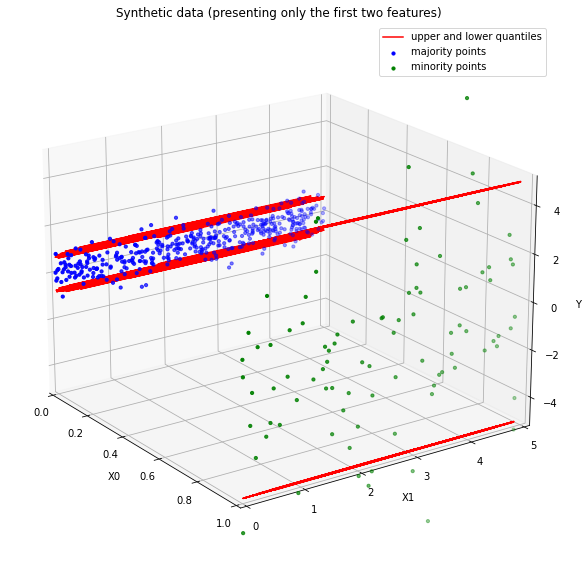

In [5]:
import torch
import numpy as np
from helper import set_seeds
set_seeds(1)

number_of_samples = 7000
minority_lambda = 3

n_features = 50
n_datasets = 1


MAJORITY_GROUP_ID = 0
groups_probabilities = [0.8, 0.2]
n_groups = len(groups_probabilities)

# the feature that determines the group belonging
group_feature = 0
            
betas = torch.rand((len(groups_probabilities),n_features))
betas = (betas.T / betas.norm(dim=1)).T

def f(x, betas):
    ax = np.zeros(len(x))
    for i in range(len(x)):

        sample_group = int(x[i,0].item())
        beta = betas[sample_group, :]

        curr_x = beta@x[i]
        if sample_group == MAJORITY_GROUP_ID:
            uncertainty = 0
        else:
            uncertainty = minority_lambda
        noise = np.random.randn(1)
        ax[i] = 0.03*curr_x*np.random.randn(1) + uncertainty*noise

    return ax.astype(np.float32)

# training features
x = np.random.uniform(0, 5.0, size=(number_of_samples,n_features)).astype(np.float32)
x[:, 0] = np.argmax(np.random.multinomial(1, groups_probabilities, size=number_of_samples), axis=1).astype(np.float32)


# generate labels
y = f(x, betas)
# reshape the features
x = x.reshape((number_of_samples,n_features))
    
plot_func(x, y)

# Data splitting and scaling

In [6]:
from datasets.datasets import get_synthetic_data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seed= 42

set_seeds(seed)
test_ratio= 0.2

x = torch.Tensor(x)
y = torch.Tensor(y.reshape(len(y), 1))

y_al = y
syn_x_train, x_te, syn_y_train, y_te = train_test_split(x,
                                                        y,
                                                        test_size=test_ratio)
unscaled_x_train = syn_x_train
unscaled_x_test = x_te

x_tr, x_va, y_tr, y_va = train_test_split(syn_x_train,
                                          syn_y_train,
                                          test_size=test_ratio)
scaler = StandardScaler().fit(x_tr)
unscaled_x_tr = x_tr
unscaled_x_va = x_va
syn_x_train = torch.Tensor(scaler.transform(syn_x_train))
x_te = torch.Tensor(scaler.transform(x_te))
x_tr = torch.Tensor(scaler.transform(x_tr))
x_va = torch.Tensor(scaler.transform(x_va))

# Model's hyperparameters
Here we define hyper-parameters shared for both Orthogonal QR and Vanilla QR.

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)
device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
args = Namespace(
    seed=seed,
    gpu=1,
    num_ep=10000,
    nl= 2,
    hs= 64,
    dropout= 0,
    lr= 1e-3,
    wd= 0,
    bs= 1024,
    wait= 200,
    corr_mult= 0,
    hsic_mult=0,
    device=device,
    num_ens=1,
    boot=0
)


## Vanilla QR

We now minimize the following objective function:
$$(\hat{q}_{\alpha_{\textrm{lo}}}, \hat{q}_{\alpha_{\textrm{hi}}}) = \operatorname*{argmin}_{f_{\alpha_{\textrm{lo}}}, f_{\alpha_{\textrm{hi}}} \in \mathcal{F}} \ \ \ {\frac{1}{n}{\sum_{i=1}^{n} {\ell_{\alpha}^\textrm{pb}(Y_i,f_{\alpha_{\textrm{lo}}}(X_i), f_{\alpha_{\textrm{hi}}}(X_i))}}},$$

where $\alpha = 0.1$, and $\alpha_\textrm{lo} =  0.05, \alpha_\textrm{hi}=0.95$.

  0%|          | 0/10000 [00:00<?, ?it/s]

Group 0 coverage (expecting 90%): 80.07%, avg. length: 1.57
Group 1 coverage (expecting 90%): 67.9%, avg. length: 6.46


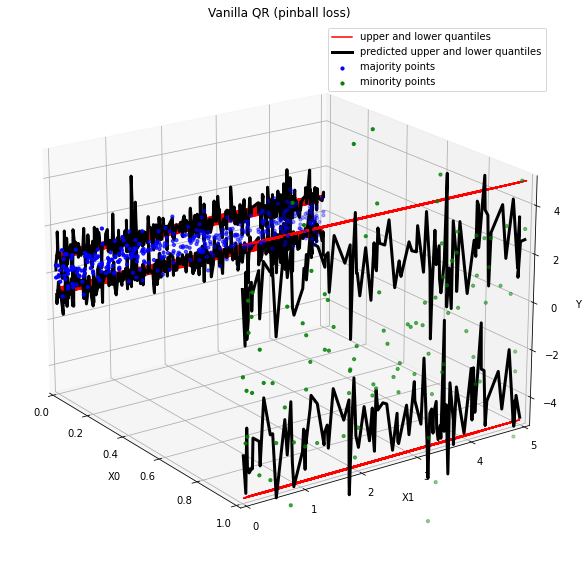

In [8]:
args.corr_mult = 0.0  # multiplier of the decorrelation loss

vanilla_qr = train_model(args, x_tr, y_tr, x_va, y_va, x_te, y_te, unscaled_x_test, "Vanilla QR")

## OQR: Orthogonal quantile regression

We minimize the following objective function:
$$(\hat{q}_{\alpha_{\textrm{lo}}}, \hat{q}_{\alpha_{\textrm{hi}}}) = \operatorname*{argmin}_{f_{\alpha_{\textrm{lo}}}, f_{\alpha_{\textrm{hi}}} \in \mathcal{F}} \ \ \ {\frac{1}{n}{\sum_{i=1}^{n} {\ell_{\alpha}^\textrm{pb}(Y_i,f_{\alpha_{\textrm{lo}}}(X_i), f_{\alpha_{\textrm{hi}}}(X_i))}}} + \frac{1}{2} \mathcal{R}_\textrm{corr}({\mathbf{L}}, {\mathbf{V}}),$$

where $\alpha = 0.1$, and $\alpha_\textrm{lo} =  0.05, \alpha_\textrm{hi}=0.95$.

  0%|          | 0/10000 [00:00<?, ?it/s]

Group 0 coverage (expecting 90%): 86.36%, avg. length: 1.59
Group 1 coverage (expecting 90%): 83.76%, avg. length: 9.24


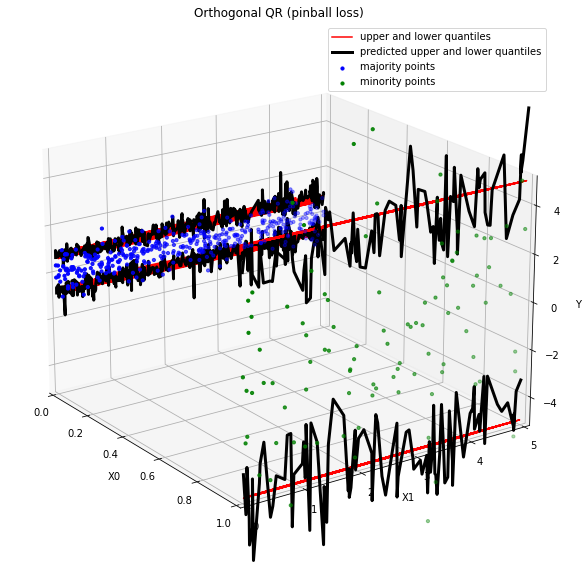

In [9]:
args.corr_mult = 0.5  # multiplier of the decorrelation loss

orthogonal_qr = train_model(args, x_tr, y_tr, x_va, y_va, x_te, y_te, unscaled_x_test, "Orthogonal QR")

# Methods comparison

Orthogonal QR results:                                          Vanilla QR results:

Group 0 coverage: 86.36%, avg. length: 1.59                     Group 0 coverage: 80.07%, avg. length: 1.57

Group 1 coverage: 83.76%, avg. length: 9.24                     Group 1 coverage: 67.9%, avg. length: 6.46



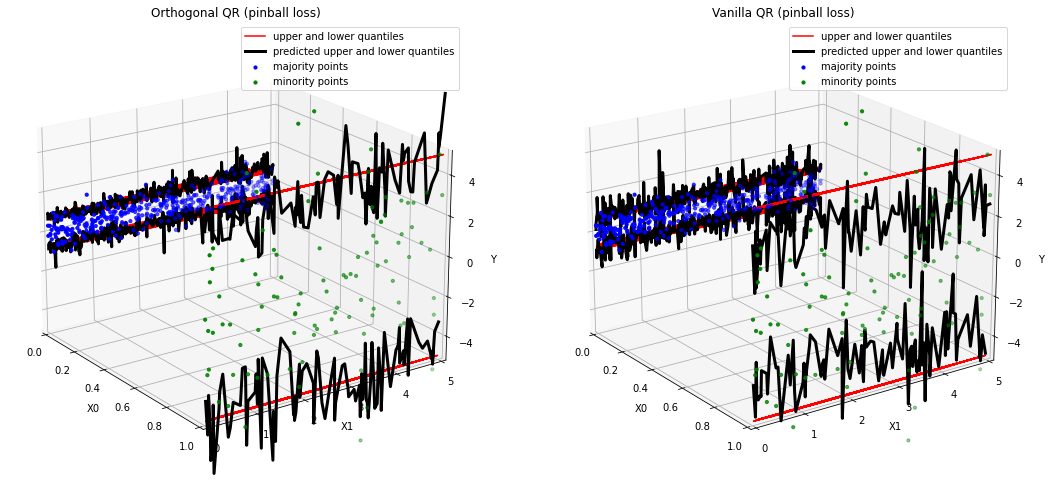

In [10]:
compare_models(orthogonal_qr, vanilla_qr, unscaled_x_test, x_te, y_te,
               "Orthogonal QR",  "Vanilla QR")

# Rerun experiments with higher noise level

Now, click [here](#syn_data_def) and set the minority noise level to 10: `minority_lambda=10`.
Then, rerun the experiments with noise level equals to 10.